In [1]:
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from glob import glob
from dask import bag
from dask.diagnostics import ProgressBar
%matplotlib inline

In [2]:
TRAIN_PATH = 'dataset/train/'
TEST_PATH = 'dataset/test/'

1) Check amount of data and data classes

In [3]:
train_ds = image_dataset_from_directory(
  TRAIN_PATH,
  seed=123,
  image_size=(224, 224))

print(train_ds.class_names)

Found 640 files belonging to 4 classes.
['caribou', 'deer', 'elk', 'moose']


2023-11-04 16:17:04.572695: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-04 16:17:04.572728: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-04 16:17:04.572738: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-04 16:17:04.573081: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-04 16:17:04.573508: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
    # print(class_names[labels[2]])
    print(labels)

tf.Tensor([3 1 2 2 2 0 2 1 1 3 0 1 1 1 1 0 3 3 2 0 0 0 3 1 2 1 1 1 2 3 1 2], shape=(32,), dtype=int32)


2) Identify Class Imbalance

2.1) Check data imbalance for trainning dataset

In [5]:
number_train_classes = {
'Caribou': len(os.listdir('dataset/train/caribou')),
'Deer': len(os.listdir('dataset/train/deer')),
'Elk': len(os.listdir('dataset/train/elk')),
'Moose': len(os.listdir('dataset/train/moose'))}

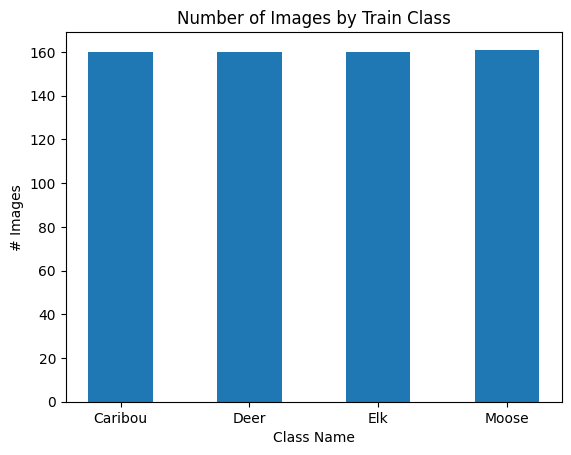

In [6]:
plt.bar(number_train_classes.keys(), number_train_classes.values(), width = .5);
plt.title("Number of Images by Train Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

2.2) Check data imbalance for testing dataset

In [7]:
number_test_classes = {
'Caribou': len(os.listdir('dataset/test/caribou')),
'Deer': len(os.listdir('dataset/test/deer')),
'Elk': len(os.listdir('dataset/test/elk')),
'Moose': len(os.listdir('dataset/test/moose'))}

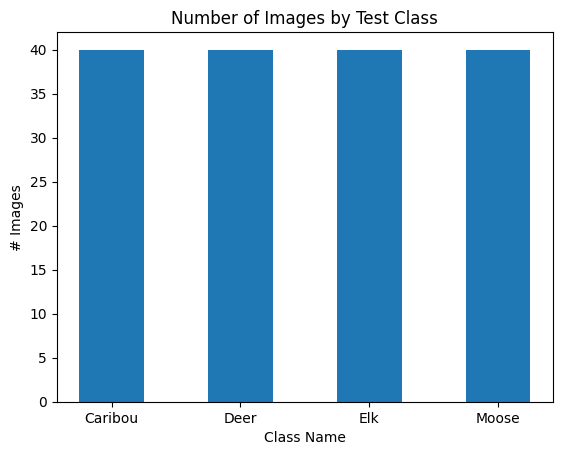

In [8]:
plt.bar(number_test_classes.keys(), number_test_classes.values(), width = .5);
plt.title("Number of Images by Test Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

3) Ploting Image Size for each class

3.1) Trainning dataset image size

In [9]:
train_size_images = dict()
for dirpath, _, filenames in os.walk(TRAIN_PATH):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, height = img.size
            train_size_images[path_image] = {'width': width, 'height': height,'path':dirpath}
train_size_images = pd.DataFrame.from_dict(train_size_images,'index')
train_size_images.reset_index(inplace=True)
train_size_images[['folder','subfolder','class']] = train_size_images['path'].str.split('/',n=3,expand=True)

UnidentifiedImageError: cannot identify image file '/Users/itthisak/Desktop/Nida/dads_7202_cnn_homework/dataset/train/.DS_Store'

Text(0.5, 0.98, "Train Dataset Image's Size")

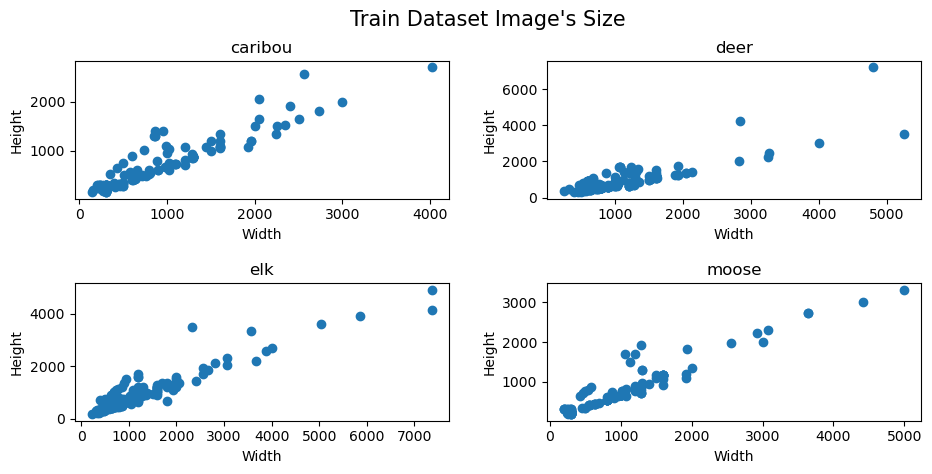

In [ ]:
class_lst = list(train_size_images['class'].unique())
fig, ax = plt.subplots(2, 2, figsize = (10, 5))
fig.tight_layout(pad=4.0)
ax = ax.ravel()
for idx,c in enumerate(class_lst,0):
    tempdf = train_size_images.loc[train_size_images['class'] == c]
    ax[idx].plot(tempdf['width'],tempdf['height'],'o')
    ax[idx].set_xlabel('Width')
    ax[idx].set_ylabel('Height')
    ax[idx].set_title(c)
fig.suptitle("Train Dataset Image's Size", fontsize=15)

3.2) Testing dataset image size

In [ ]:
test_size_images = dict()
for dirpath, _, filenames in os.walk(TEST_PATH):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, height = img.size
            test_size_images[path_image] = {'width': width, 'height': height,'path':dirpath}
test_size_df = pd.DataFrame.from_dict(test_size_images,'index')
test_size_df.reset_index(inplace=True)
test_size_df[['folder','subfolder','class']] = test_size_df['path'].str.split('/',n=3,expand=True)

Text(0.5, 0.98, "Test Dataset Image's Size")

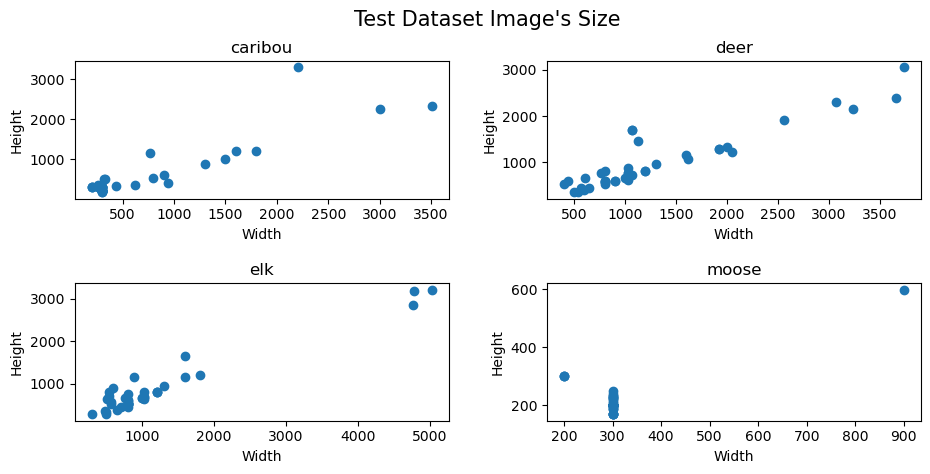

In [ ]:
class_lst = list(test_size_df['class'].unique())
fig, ax = plt.subplots(2, 2, figsize = (10, 5))
fig.tight_layout(pad=4.0)
ax = ax.ravel()
for idx,c in enumerate(class_lst,0):
    tempdf = test_size_df.loc[test_size_df['class'] == c]
    ax[idx].plot(tempdf['width'],tempdf['height'],'o')
    ax[idx].set_xlabel('Width')
    ax[idx].set_ylabel('Height')
    ax[idx].set_title(c)
fig.suptitle("Test Dataset Image's Size", fontsize=15)

4) Check the image color type: RGB or Grayscale ?

In [ ]:
directories = {
    'caribou': TRAIN_PATH + '/caribou/',
    'deer': TRAIN_PATH + '/deer/',
    'elk': TRAIN_PATH + '/elk/',
    'moose': TRAIN_PATH + '/moose/'
}

In [ ]:
def get_image_type(image_path):
    """
    Determine if an image is 'grayscale' or 'rgb'.
    """
    im = Image.open(image_path)
    arr = np.array(im)
    if len(arr.shape) == 2:
        return 'grayscale'
    elif len(arr.shape) == 3 and arr.shape[2] == 3:
        return 'rgb'
    else:
        return 'other'  # Might catch cases like RGBA or other unexpected formats.
 
def count_image_types_and_get_grayscale_filenames(directory_path):
    """
    Count the number of 'grayscale' and 'rgb' images in a directory and
    return filenames of 'grayscale' images.
    """
    grayscale_count = 0
    rgb_count = 0
    grayscale_filenames = []
 
    for fname in os.listdir(directory_path):
        image_path = os.path.join(directory_path, fname)
        img_type = get_image_type(image_path)
        if img_type == 'grayscale':
            grayscale_count += 1
            grayscale_filenames.append(fname)
        elif img_type == 'rgb':
            rgb_count += 1
 
    return grayscale_count, rgb_count, grayscale_filenames
 
# Loop through each directory and count image types
for animal, dir_path in directories.items():
    grayscale_count, rgb_count, grayscale_files = count_image_types_and_get_grayscale_filenames(dir_path)
    print(f"For {animal}:")
    print(f"Number of grayscale images: {grayscale_count}")
    print(f"Number of RGB images: {rgb_count}")
    print(f"Filenames of grayscale images: {grayscale_files}")
    print("-" * 50)

For caribou:
Number of grayscale images: 2
Number of RGB images: 158
Filenames of grayscale images: ['Female_Caribou26.png', 'Male_Caribou54.png']
--------------------------------------------------
For deer:
Number of grayscale images: 0
Number of RGB images: 160
Filenames of grayscale images: []
--------------------------------------------------
For elk:
Number of grayscale images: 0
Number of RGB images: 160
Filenames of grayscale images: []
--------------------------------------------------
For moose:
Number of grayscale images: 0
Number of RGB images: 160
Filenames of grayscale images: []
--------------------------------------------------


5) Display sample images of each class

5.1) Random disply sample images

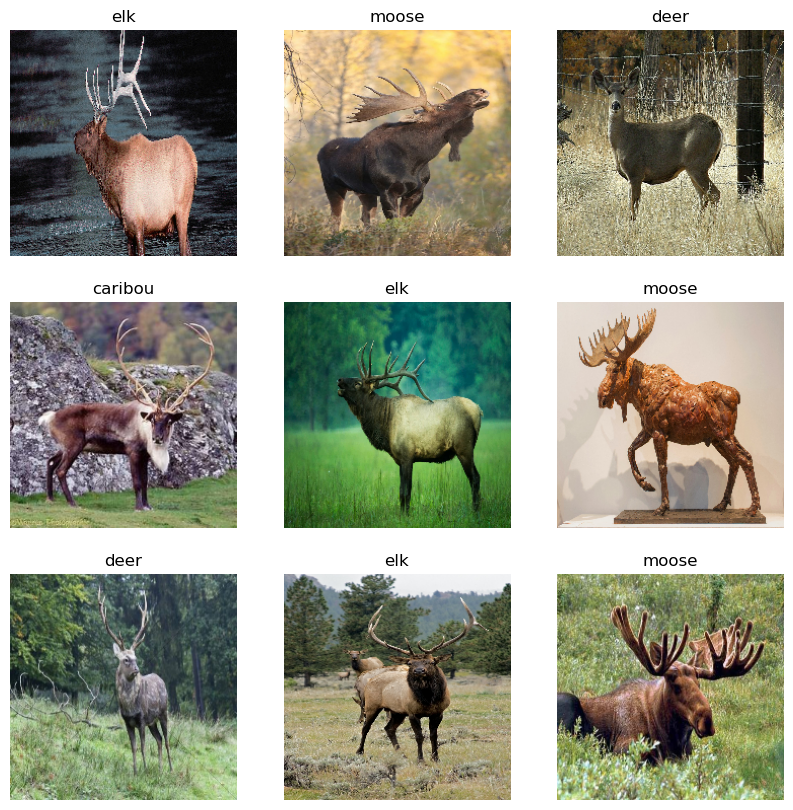

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

5.2) Display sample images of Deer

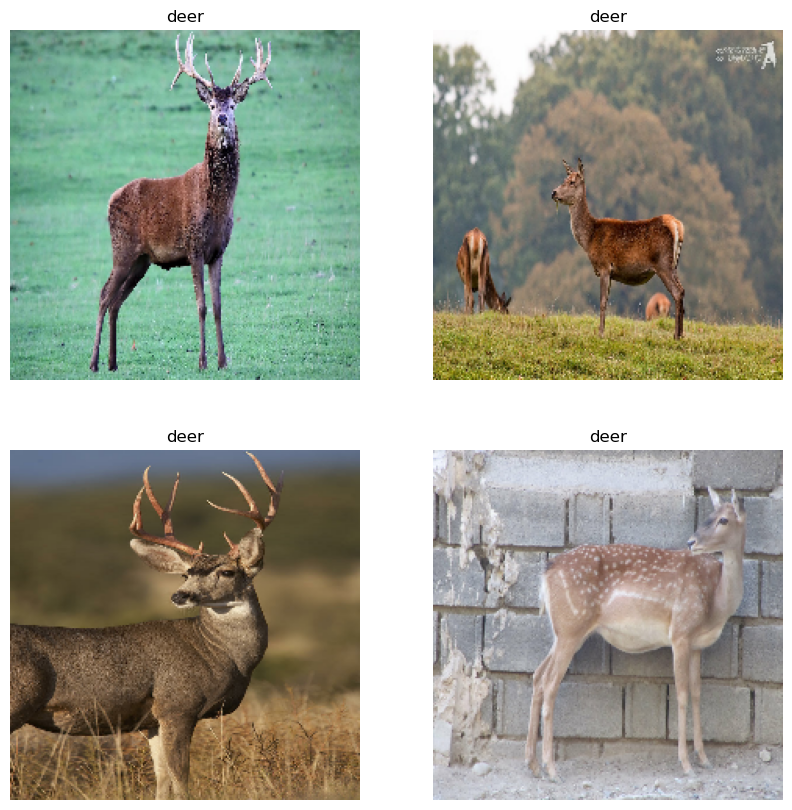

In [ ]:
deer_train_ds = train_ds.map(lambda x, y:  (x[y==1], y[y==1]))
plt.figure(figsize=(10, 10))
for images, labels in deer_train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

5.3) Display sample images of Elk

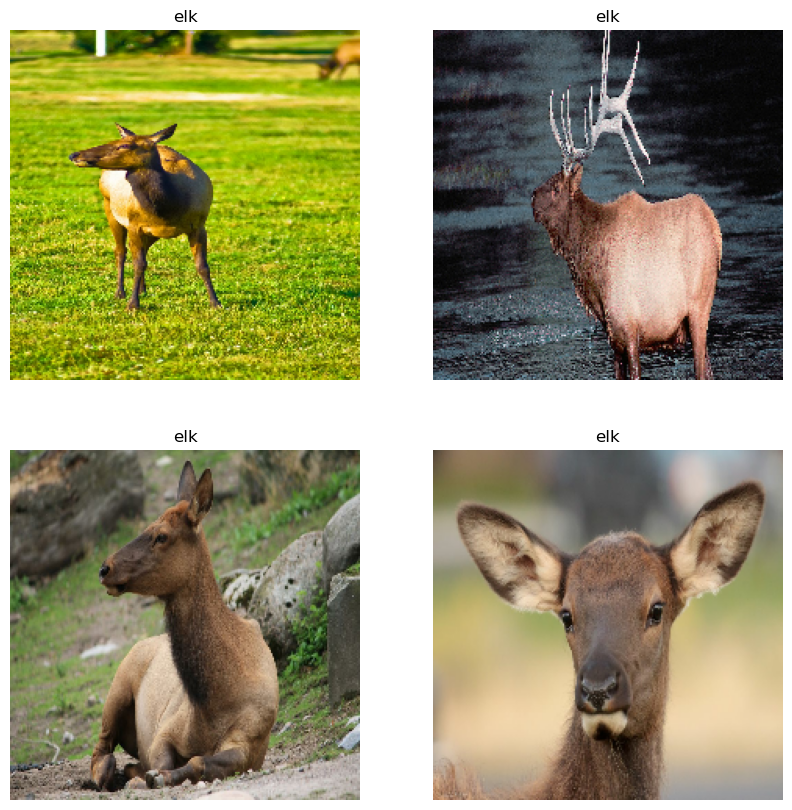

In [ ]:
elk_train_ds = train_ds.map(lambda x, y:  (x[y==2], y[y==2]))
plt.figure(figsize=(10, 10))
for images, labels in elk_train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

5.4) Display sample images of Caribou

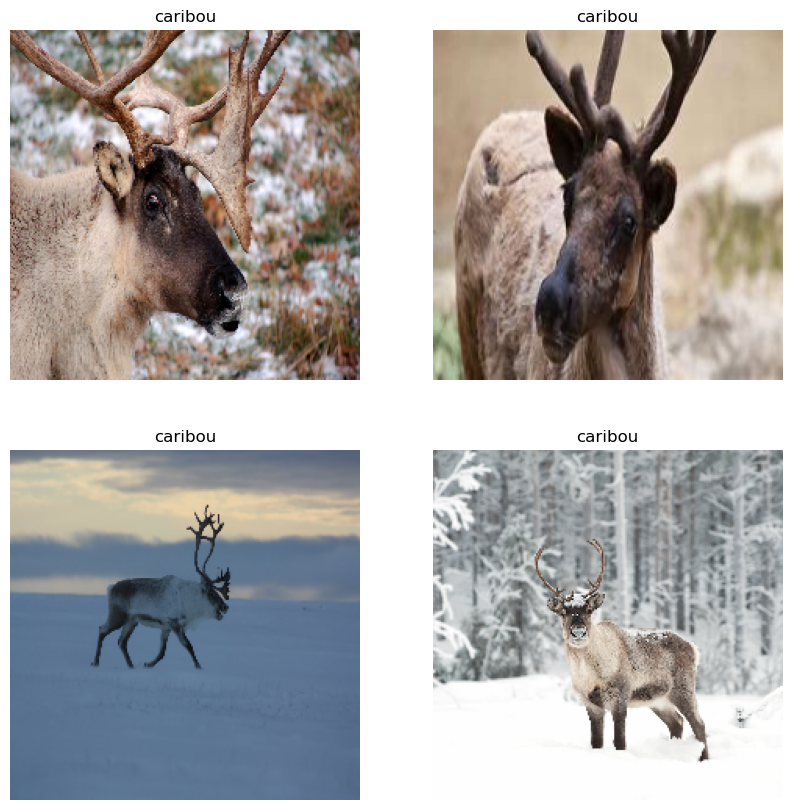

In [ ]:
caribou_train_ds = train_ds.map(lambda x, y:  (x[y==0], y[y==0]))
plt.figure(figsize=(10, 10))
for images, labels in caribou_train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

5.5) Display sample images of Moose

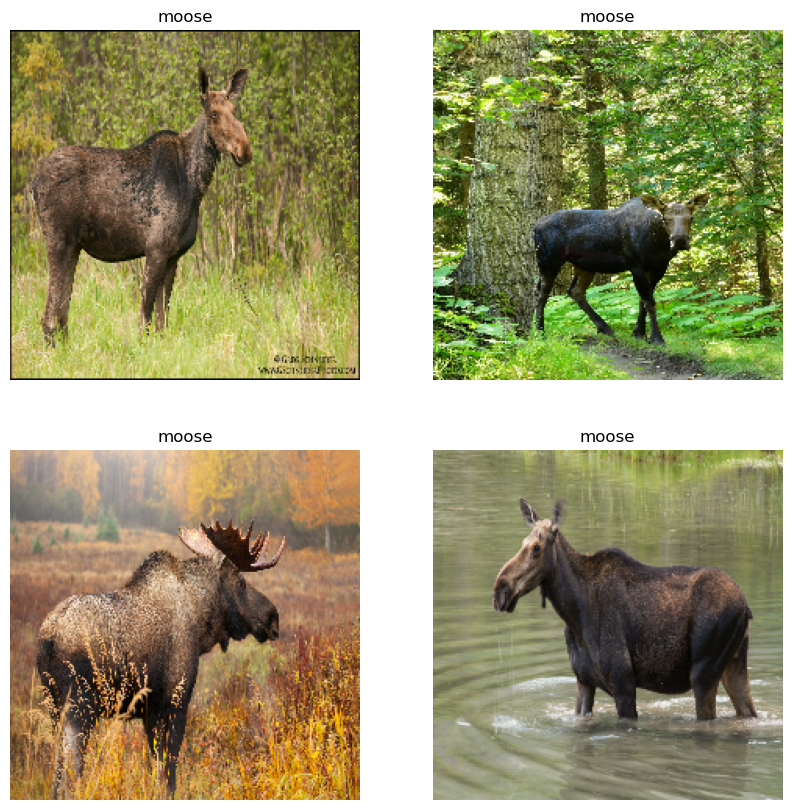

In [ ]:
moose_train_ds = train_ds.map(lambda x, y:  (x[y==3], y[y==3]))
plt.figure(figsize=(10, 10))
for images, labels in moose_train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")